In [234]:
# Unsucessful MLP with Bad Data

import glob
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import sys

#accensions and seperations raw data files

accData = 'C:/Users/604070/Desktop/Files/Performance/OPM_HR_Analytics/Model_Development/Data/ACC/ACCDATA_FY2011-2017.TXT'
sepData = 'C:/Users/604070/Desktop/Files/Performance/OPM_HR_Analytics/Model_Development/Data/SEP/SEPDATA_FY2011-2017.TXT'


def load_emp_fact():

    '''Load OPM Employment Cube data
       Output: Return processed df of 2018 data'''

    df_total = pd.DataFrame()

    for name in glob.glob(empCube):


        df = pd.read_csv(name,dtype={ 'AGYSUB': str, 'LOC': str, 'AGELVL': str, 'EDLVL': str, 'GSEGRD': str, 'LOSLVL': str, 'OCC': str, 'PATCO': str,
       'PPGRD': str, 'SALLVL': str, 'STEMOCC': str, 'SUPERVIS': str, 'TOA': str, 'WORKSCH': str, 'WORKSTAT': str,
       'DATECODE': str, 'EMPLOYMENT': str, 'SALARY': str, 'LOS': float})    
        df_total = pd.concat([df_total, df])

    #clean salary col cast to integer
    df_total['SALARY'] = df_total['SALARY'].str.replace('$','')
    df_total['SALARY'] = df_total['SALARY'].str.replace(',','')

    df_total = df_total.dropna(axis = 0, how = 'any')

    df_total['SALARY'] = df_total['SALARY'].astype(int)
    
    df_total.drop(['EDLVL', 'EMPLOYMENT', 'STEMOCC', 'SUPERVIS', 'WORKSTAT'], axis = 1 ,inplace = True)
    
    #just 2018 data 
    df_2018 = df_total.loc[df_total['DATECODE'] == '201803']
    
    df_2018_date = df_2018.drop(['DATECODE'], axis =1)
    
    return df_2018_date


def load_acc_fact():

    '''Load accessions data
    
       Output: returns clean dataframe of all accensions data'''

    print('Loading data...')

    df = pd.read_csv(accData, low_memory=False)

    df = df.dropna(axis = 0, how = 'any')

    df['SALARY'] = df['SALARY'].astype(int)
    
    return df    

def load_sep_fact():

    '''Load separations data
    
       Output: returns clean dataframe of all seperations data'''

    df = pd.read_csv(sepData, low_memory=False)

    df = df.dropna(axis = 0, how = 'any')

    df['SALARY'] = df['SALARY'].astype(int)
    
    df = df[df['OCC'] != '****']

    df = df[df['TOA'] != '**']

    return df




def load_dim_table():

    '''load reference tables
    
    Output: returns a list containing dataframes of each reference table '''

    ref_list = []

    for name in glob.glob(refData):

        ref_list.append(pd.read_csv(name))

    return ref_list  



def join_func( df, df_other):
    
    '''Input: two inputs... df a given dataframe ... df_other a given dataframe to be joined to df
       
       Output: Returns a dataframe containing containing both input dataframes '''

    df = df.merge(df_other)

    return df


def joins(df, data):
    
    '''Inputs: df- dataframe to join reference tables; data - flag used to specify which refrence tables to join
    
       Output: Returns dataframe joined to reference tables'''
    
    #indexing based on number and order of reference tables found in the directory

    dim = load_dim_table()

    acc = dim[0]
    age = dim[1]
    agency = dim[2]
    education = dim[4]
    date = dim[5]
    grade = dim[6][1:]
    location = dim[7]
    los = dim[8]
    occ = dim[9]
    patco = dim[10]
    paygroup = dim[11]
    salary = dim[12]
    separation = dim[13]
    stem = dim[14]
    supervisor = dim[15]  
    toa = dim[16]
    workstat = dim[17]
    worksch = dim[18]

    # load fact table 

    df_join = df

    '''reference tables joined to acc/sep fact tables'''  

    if (data == 'accessions'):

        df_join = join_func(df_join, acc)
        
        df_join = join_func(df_join, date)
        
        df_join = join_func(df_join, patco)
    
    elif(data =='separations'):

        df_join = join_func(df_join, separation)
        
        df_join = join_func(df_join, date)
        
        df_join = join_func(df_join, patco)
    
    else:
        
        pass
    

    df_join = join_func(df_join, age)

    df_join = join_func(df_join, agency)    

    df_join = join_func(df_join, location)

    df_join = join_func(df_join, los)

    df_join = join_func(df_join, paygroup)

    df_join = join_func(df_join, salary)

    df_join = join_func(df_join, toa)

    df_join = join_func(df_join, worksch)

    df_join = join_func(df_join, occ)

    return df_join



def join_dim_tables():   

    '''Reduce accension and separation data in star schema to dataframe
    
       Output: returns the accessions and separations data joined to all relevant reference tables'''


    df_joins_acc = joins(load_acc_fact(), 'accessions')

    df_joins_sep = joins(load_sep_fact(), 'separations')


    return df_joins_acc, df_joins_sep  


def raw_data():
    
    '''Load complete accension and separations data '''
    
    acc, sep = join_dim_tables()

    rawData = pd.concat([acc, sep], axis = 0, sort = True)
    
    rawData['EFDATE'] = rawData['EFDATE'].astype(str)

    rawDatalabel = rawData.loc[:,('ACCT','SEPT')]

    rawDatalabel['ACCT'].update(rawDatalabel.pop('SEPT'))
    
    rawDatalabel['ACCT'] = rawDatalabel['ACCT'].apply(lambda x: 1 if x == 'Quit' else 0)
    
    data = pd.concat([rawData, rawDatalabel['ACCT']], axis = 1 )
    
    data.drop(['ACC','LOSLVL','TOATYP','AGELVL','OCCTYP','PPTYP', 'PPTYPT', 'SEPT', 'AGY', 'AGYSUB', 'AGYTYP', 'EFDATE', 'FY', 'LOC', 'LOCTYP', 'OCC', 'OCCFAM','PAYPLAN','PPGROUP','WORKSCH', 'WSTYP','SALLVL','SEP', 'TOA', 'QTR', 'PATCO'  ], axis =1, inplace=True)

    return data


def pre_process():
    
    data = raw_data()
    
    data = data.iloc[:,1:]
    data['Year'] = data['EFDATET'].apply(lambda x: x[4:])
    data['Month'] = data['EFDATET'].apply(lambda x: x[:2])
    data['QTRT'] = data['QTRT'].apply(lambda x: x[:7])
    
    data_dummy = pd.get_dummies(data[['AGELVLT', 'AGYSUBT', 'AGYT', 'AGYTYPT', 'COUNT', 'FYT',
       'GSEGRD', 'LOCT', 'LOCTYPT', 'LOS', 'LOSLVLT', 'OCCFAMT', 'OCCT',
       'OCCTYPT', 'PATCOT', 'PAYPLANT', 'PPGRD', 'PPGROUPT', 'QTRT', 'SALARY',
       'SALLVLT', 'TOAT', 'TOATYPT', 'WORKSCHT', 'WSTYPT', 'ACCT',
       'Year', 'Month']])
    
    whole = pd.concat([data_dummy, data['EFDATET']], axis = 1)
    # 2017 data removed for testing data 
    test_data = whole[whole['Year_2017'] == 1]
    
    train_data = whole[whole['Year_2017'] != 1]
    
    test_data = test_data.drop(['Year_2017'], axis = 1)
    
    train_data = train_data.drop(['Year_2017'], axis = 1)
    
    return train_data, test_data


def normalize(df):
    
    df = df.groupby('EFDATET').sum()
    
    for col in list(df.columns):
       
        mean, std = df[col].mean(), df[col].std()

        df.loc[:, col] = (df[col] -mean) /(std + 1) 
        
    
        
    y = df['ACCT'].reset_index().iloc[:,1]
    
    y = y.values
    
    X = df.drop(['ACCT'], axis = 1).reset_index().iloc[:,1:]
    
    X = X.values
        
    return X, y, df
    
    


In [235]:
a, b = pre_process()

Loading data...


In [236]:
#processed training data 
X, y, df = normalize(a)

In [467]:
class deepNet(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.learning_rate = learning_rate
        
        self.weights_input_to_hidden = np.random.normal(0, self.input_nodes**-0.5, (self.hidden_nodes, self.input_nodes))
        self.weights_hidden_to_output = np.random.normal(0, self.hidden_nodes**-0.5, (self.hidden_nodes, self.output_nodes))
        
        self.activation = lambda x : 1 /( 1 + np.exp(-x))
            
    def forward_feed(self, inputs):
        
        hidden_inputs = np.dot(inputs, self.weights_input_to_hidden.T)
        
        hidden_outputs = self.activation(hidden_inputs)
        
        # output layer 
        
        inputs_to_output = np.dot(hidden_outputs, self.weights_hidden_to_output.reshape(self.hidden_nodes,1))
                
        output_of_output = self.activation(inputs_to_output)
        
        return hidden_outputs, output_of_output
        
    def back_propagation(self, final_outputs, y, hidden_outputs_1, inputs, weights_change_i_h, weights_change_h_o):
        
        #self, inputs, labels, hidden_outputs, final_outputs, weights_change_i_h, weights_change_h_o
        
        final_outputs = final_outputs.reshape(final_outputs.shape[0],)
        
        error = y - final_outputs
                
        #derivative of error 
        
        error_prime = error * final_outputs * (1 - final_outputs)
        
        hidden_error = np.dot(self.weights_hidden_to_output.reshape(self.hidden_nodes,1), error_prime[:,None].T)
        
        hidden_error_prime = hidden_error.T * (hidden_outputs_1 * (1 - hidden_outputs_1))
        
        weights_change_h_o = np.dot(error_prime[:, None].T, hidden_outputs_1)
        
        weights_change_i_h = np.dot(hidden_error_prime.T, inputs)
                
        return weights_change_i_h, weights_change_h_o
    
    def update_weights(self, weights_change_i_h, weights_change_h_o, n):
        
        self.weights_input_to_hidden += self.learning_rate * weights_change_i_h / n 
        
        self.weights_hidden_to_output += (self.learning_rate * weights_change_h_o / n).reshape(self.hidden_nodes,1)
        
    def train(self, features, targets):
        
        #number of rows in dataset...corresponds to number of months 
        n = features.shape[0]
        
        # initialize weights matrices with zeros 
        weights_change_i_h = np.zeros(self.weights_input_to_hidden.shape)
        weights_change_h_o = np.zeros(self.weights_hidden_to_output.shape)
        
        # forward feed 
        hid_outs, fin_outs = self.forward_feed(features)
        
        # backwards_feed 
        
        weights_change_i_h, weights_change_h_o =  self.back_propagation(fin_outs, targets, hid_outs, features, weights_change_i_h, weights_change_h_o)
        
        # update weights 
        
        self.update_weights(weights_change_i_h, weights_change_h_o, n)
        
    def run_model(self, inputs):
        
        hidden_inputs = np.dot(inputs, self.weights_input_to_hidden.T)
        
        hidden_outputs = self.activation(hidden_inputs)
        
        # output Layer 
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
        
        final_outputs = self.activation(final_inputs)
        
        return final_outputs
        

In [468]:
def meanError(y, Y):
        
        return np.mean((y-Y)**2)

In [478]:
model = deepNet(X.shape[1],64,1,.001)

In [479]:
#training model taking samples of n data points

loss = []
n = 75
cycles = 100000
for i in range(cycles):
    df_X = pd.DataFrame.from_records(X)
    batch = np.random.choice(df_X.index, size = n)
    
    model.train(X[batch], y[batch]) 
    
    output = model.run_model(X)
    
    target = y[:, None]
    
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * i/float(cycles)) + "% ... Training loss: " + str(meanError(output,target)))
    
    loss.append(meanError(output,target))

Progress: 100.0% ... Training loss: 0.5634983301825125

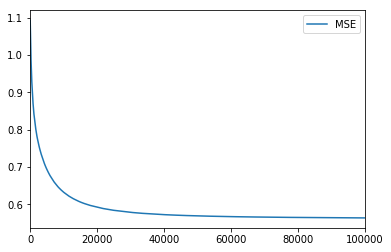

In [480]:
# Mean squared losses on the training data ....
df_loss = pd.DataFrame(loss, columns= ['MSE'])
df_loss.plot()

In [472]:
#Batch sizes 
X[batch].shape, y[batch].shape

((75, 1425), (75,))

In [242]:
#normalized data
df

,COUNT,LOS,SALARY,ACCT,AGELVLT_20-24,AGELVLT_25-29,AGELVLT_30-34,AGELVLT_35-39,AGELVLT_40-44,AGELVLT_45-49,...,Month_AP,Month_AU,Month_DE,Month_FE,Month_JA,Month_JU,Month_MA,Month_NO,Month_OC,Month_SE
EFDATET,,,,,,,,,,,,,,,,,,,,,
APR 2011,-0.277052,-0.340940,-0.592929,-0.210344,-0.253515,-0.115333,-0.473770,-0.620769,0.097102,0.216274,...,3.418725,-0.288560,-0.313575,-0.290976,-0.291429,-0.425667,-0.412673,-0.315232,-0.311519,-0.291356
APR 2012,-0.160678,0.016540,-0.446974,-0.178036,-0.042140,0.054467,-0.412796,-0.645503,-0.446669,-0.422766,...,3.524697,-0.288560,-0.313575,-0.290976,-0.291429,-0.425667,-0.412673,-0.315232,-0.311519,-0.291356
APR 2013,-0.872394,-0.757419,-1.225019,-0.076193,-0.626532,-0.575581,-0.798966,-0.908740,-0.949173,-0.780351,...,2.876594,-0.288560,-0.313575,-0.290976,-0.291429,-0.425667,-0.412673,-0.315232,-0.311519,-0.291356
APR 2014,-0.720146,-0.384999,-0.780895,-0.378210,-0.670615,-0.336073,-0.252738,-0.475900,-0.888484,-0.948762,...,3.015234,-0.288560,-0.313575,-0.290976,-0.291429,-0.425667,-0.412673,-0.315232,-0.311519,-0.291356
APR 2015,-0.143353,-0.390907,-0.224565,-0.350115,-0.640661,0.047318,0.588198,0.554082,0.606888,-0.012119,...,3.540473,-0.288560,-0.313575,-0.290976,-0.291429,-0.425667,-0.412673,-0.315232,-0.311519,-0.291356
APR 2016,0.090968,0.129576,0.417502,-0.152048,-0.608446,0.113450,0.645362,1.029323,0.487938,0.419290,...,3.753852,-0.288560,-0.313575,-0.290976,-0.291429,-0.425667,-0.412673,-0.315232,-0.311519,-0.291356
AUG 2011,1.758522,0.151648,1.322760,4.553802,2.264344,0.772097,0.273165,0.776686,1.757547,1.999586,...,-0.291733,4.365613,-0.313575,-0.290976,-0.291429,-0.425667,-0.412673,-0.315232,-0.311519,-0.291356
AUG 2012,0.770660,-0.291823,0.312875,4.003147,1.885676,0.380662,0.048322,-0.159662,0.186921,-0.062873,...,-0.291733,3.613156,-0.313575,-0.290976,-0.291429,-0.425667,-0.412673,-0.315232,-0.311519,-0.291356
AUG 2013,-0.880269,-0.654188,-1.046292,1.879193,0.095198,-0.556814,-0.718937,-0.884007,-1.386132,-1.456302,...,-0.291733,2.355639,-0.313575,-0.290976,-0.291429,-0.425667,-0.412673,-0.315232,-0.311519,-0.291356


In [243]:
df_original = a.groupby('EFDATET').sum()
df_original

,COUNT,LOS,SALARY,ACCT,AGELVLT_20-24,AGELVLT_25-29,AGELVLT_30-34,AGELVLT_35-39,AGELVLT_40-44,AGELVLT_45-49,...,Month_AP,Month_AU,Month_DE,Month_FE,Month_JA,Month_JU,Month_MA,Month_NO,Month_OC,Month_SE
EFDATET,,,,,,,,,,,,,,,,,,,,,
APR 2011,23284,149375.3,1208276631,3815,2401.0,3412.0,2813.0,1968.0,2229.0,2212.0,...,23284.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
APR 2012,23949,173020.0,1251052908,3861,2775.0,3602.0,2861.0,1954.0,2005.0,1935.0,...,23949.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
APR 2013,19882,121828.2,1023024272,4006,1741.0,2897.0,2557.0,1805.0,1798.0,1780.0,...,19882.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
APR 2014,20752,146461.1,1153187571,3576,1663.0,3165.0,2987.0,2050.0,1823.0,1707.0,...,20752.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
APR 2015,24048,146070.3,1316236282,3616,1716.0,3594.0,3649.0,2633.0,2439.0,2113.0,...,24048.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
APR 2016,25387,180496.5,1504412655,3898,1773.0,3668.0,3694.0,2902.0,2390.0,2300.0,...,25387.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AUG 2011,34916,181956.4,1769724920,10598,6856.0,4405.0,3401.0,2759.0,2913.0,2985.0,...,0.0,34916.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AUG 2012,29271,152624.0,1473748818,9814,6186.0,3967.0,3224.0,2229.0,2266.0,2091.0,...,0.0,29271.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AUG 2013,19837,128656.2,1075405272,6790,3018.0,2918.0,2620.0,1819.0,1618.0,1487.0,...,0.0,19837.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [244]:
mean = df_original.COUNT.mean()

In [245]:
std = df_original.COUNT.std()

In [246]:
actuals = df.COUNT * (std + 1) + mean
actuals[:5] 

EFDATET
APR 2011    23284.0
APR 2012    23949.0
APR 2013    19882.0
APR 2014    20752.0
APR 2015    24048.0
Name: COUNT, dtype: float64

In [481]:
predictions = model.run_model(X)

In [482]:
unnormalized_predictions = (predictions * (std + 1) + mean).round()


In [352]:
#actuals = actuals.reset_index()

In [483]:
table = pd.concat([actuals, pd.DataFrame(unnormalized_predictions, columns = ['PREDICTIONS'])], axis = 1)

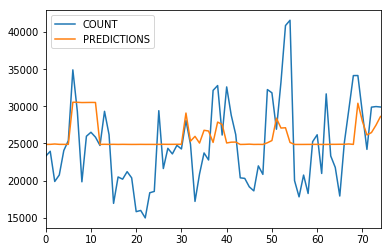

In [484]:
#Predictions compared to TRAINING!!! set 

table[['EFDATET', 'COUNT', 'PREDICTIONS']].plot()

In [485]:
table[['EFDATET', 'COUNT', 'PREDICTIONS']]

,EFDATET,COUNT,PREDICTIONS
0,APR 2011,23284.0,24871.0
1,APR 2012,23949.0,24882.0
2,APR 2013,19882.0,24930.0
3,APR 2014,20752.0,24882.0
4,APR 2015,24048.0,24880.0
5,APR 2016,25387.0,24880.0
6,AUG 2011,34916.0,30559.0
7,AUG 2012,29271.0,30548.0
8,AUG 2013,19837.0,30513.0
9,AUG 2014,25973.0,30521.0
